# Colts Game 1 (2025): Data Pull, Integrity Checks, and EDA
### Grant Starnes
### 2025-09-20

## First, we want to load the necessary libraries from the original NFLReadrPhaseI document, just in Python this time compared to R

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nfl_data_py as nfl
from datetime import datetime

## We then want to set our parameters, Colts as the team and the season as 2025

In [3]:
sns.set_theme(style="whitegrid")

TEAM = "IND"
SEASON = 2025

## We then want to access the data and locate the Colts' first regular-season game, where they played the Miami Dolphins

In [4]:
# Load full season schedule
sched = nfl.import_schedules([SEASON])

# Filter to regular season Colts games
colts_sched = sched[(sched['game_type'] == 'REG') &
                    ((sched['home_team'] == TEAM) | (sched['away_team'] == TEAM))]

# Sort and grab Week 1 game
colts_game1 = colts_sched.sort_values(['gameday', 'week']).iloc[0]

game_id = colts_game1['game_id']
week = colts_game1['week']
gameday = colts_game1['gameday']
home_tm = colts_game1['home_team']
away_tm = colts_game1['away_team']
opp = away_tm if home_tm == TEAM else home_tm

print(f"Found Colts Week {week} ({gameday}): {away_tm} @ {home_tm} | game_id = {game_id}")

Found Colts Week 1 (2025-09-07): MIA @ IND | game_id = 2025_01_MIA_IND


## Here, we want to pull the necessary data, the play-by-play data from Game 1, the rosters for both teams, and the officials for the game

In [5]:
# Play-by-play data
pbp = nfl.import_pbp_data([SEASON])
pbp_g1 = pbp[pbp['game_id'] == game_id].copy()

# Rosters
rosters = nfl.import_weekly_rosters([SEASON])
rw_g1 = rosters[(rosters['week'] == week) & (rosters['team'].isin([TEAM, opp]))]

# Officials
officials = nfl.import_officials([SEASON])
officials_g1 = officials[officials['game_id'] == game_id]

# Player master data
players_master = nfl.import_players()

print("PBP plays:", len(pbp_g1))
print("Roster rows:", len(rw_g1))
print("Officials rows:", len(officials_g1))

2025 done.
Downcasting floats.
PBP plays: 152
Roster rows: 201
Officials rows: 7


## Here, we want to ensure there are no duplicate plays in the play-by-play data, and make sure all plays are unique. We also want to check for missingness

In [6]:
# Check for duplicate plays
dup_plays = pbp_g1[pbp_g1.duplicated(subset=['game_id', 'play_id'], keep=False)]
if not dup_plays.empty:
    print("Duplicate plays found!")
else:
    print("No duplicate plays.")

# Missingness summary
na_summary = pbp_g1[['epa', 'success', 'posteam', 'defteam',
                     'yardline_100', 'down', 'ydstogo', 'play_type']].isna().mean()
print("Missingness:\n", na_summary)

No duplicate plays.
Missingness:
 epa             0.013158
success         0.013158
posteam         0.065789
defteam         0.065789
yardline_100    0.078947
down            0.171053
ydstogo         0.000000
play_type       0.032895
dtype: float64


In [7]:
pbp_g1['points_scored'] = np.select(
    [
        pbp_g1['touchdown'] == 1,
        pbp_g1['field_goal_result'] == 'made',
        pbp_g1['safety'] == 1,
        pbp_g1['extra_point_result'] == 'good',
        (pbp_g1['two_point_attempt'] == 1) & (pbp_g1['two_point_conv_result'] == 'success')
    ],
    [6, 3, 2, 1, 2],
    default=0
)

## Here, we want to create a plot that shows the scoring per quarter

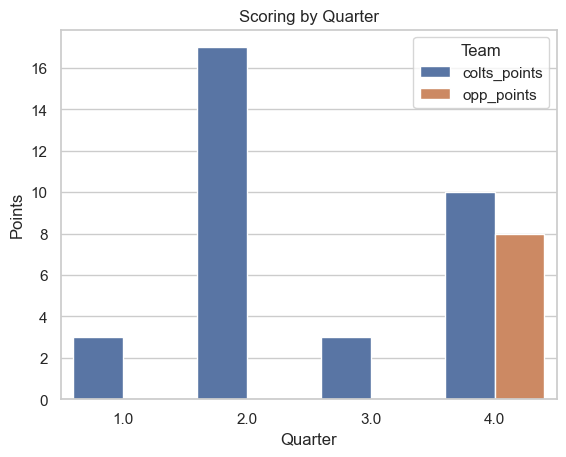

In [8]:
score_by_q = (
    pbp_g1[pbp_g1['qtr'].isin([1,2,3,4])]
    .groupby('qtr')
    .agg(
        colts_points=('points_scored', lambda x: x[pbp_g1['posteam'] == TEAM].sum()),
        opp_points=('points_scored', lambda x: x[pbp_g1['posteam'] == opp].sum()),
        plays=('play_id', 'count')
    )
    .reset_index()
)

# Plot stacked bars
score_by_q_melt = score_by_q.melt(id_vars='qtr', value_vars=['colts_points', 'opp_points'],
                                  var_name='Team', value_name='Points')

sns.barplot(data=score_by_q_melt, x='qtr', y='Points', hue='Team')
plt.title('Scoring by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Points')
plt.show()

## Now we want to determine the Colts' offensive play mix

/var/folders/wl/mr0t_6yx7bd85zhwy66s84hh0000gn/T/ipykernel_96252/1852360399.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=off_mix[off_mix['posteam'] == TEAM],


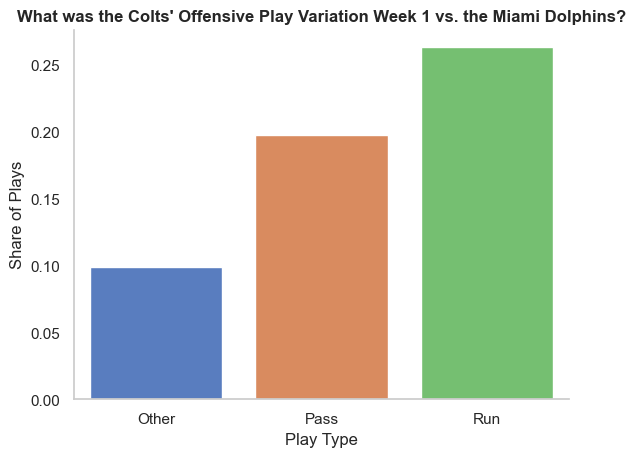

In [14]:
# Classify plays into categories
def classify_play(play_type):
    if play_type == "run":
        return "Run"
    elif play_type == "pass":
        return "Pass"
    elif play_type in ["qb_kneel", "qb_spike"]:
        return "Clock"
    elif play_type in ["no_play", "timeout"]:
        return "Other"
    else:
        return "Other"

pbp_g1['play_family'] = pbp_g1['play_type'].apply(classify_play)

off_mix = (
    pbp_g1[pbp_g1['posteam'].notna()]
    .groupby(['posteam', 'play_family'])
    .agg(
        plays=('play_id', 'count'),
        epa_per_play=('epa', 'mean'),
        success_rate=('success', 'mean'),
        yards_per_play=('yards_gained', 'mean')
    )
    .reset_index()
)
off_mix['share'] = off_mix['plays'] / len(pbp_g1)

ax = sns.barplot(data=off_mix[off_mix['posteam'] == TEAM], 
            x='play_family', y='share', palette='muted')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("What was the Colts' Offensive Play Variation Week 1 vs. the Miami Dolphins?", fontweight = 'bold')
plt.xlabel('Play Type')
plt.ylabel('Share of Plays')
plt.grid(False)
plt.show()

## Now we'd like to see the EPA distribution per play comparing the Colts and the Dolphins

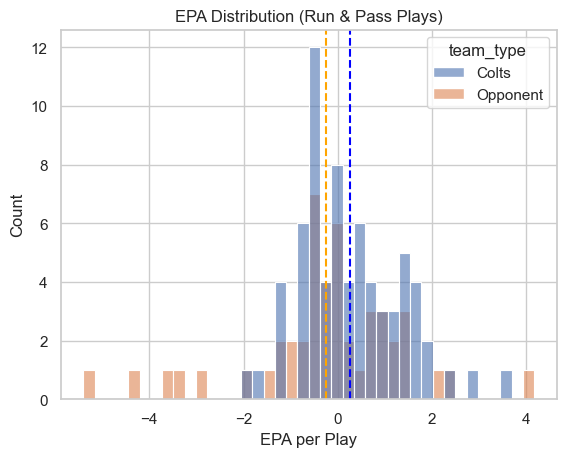

In [56]:
epa_dist = pbp_g1[pbp_g1['play_type'].isin(['run', 'pass'])].copy()
epa_dist['team_type'] = np.where(epa_dist['posteam'] == TEAM, 'Colts', 'Opponent')

sns.histplot(data=epa_dist, x='epa', hue='team_type', bins=40, kde=False, alpha=0.6)
plt.axvline(epa_dist.groupby('team_type')['epa'].mean()['Colts'], color='blue', linestyle='--')
plt.axvline(epa_dist.groupby('team_type')['epa'].mean()['Opponent'], color='orange', linestyle='--')
plt.title('EPA Distribution (Run & Pass Plays)')
plt.xlabel('EPA per Play')
plt.show()

## Here, we would like to see the situational success rate for each team based on the down and yards-to-go

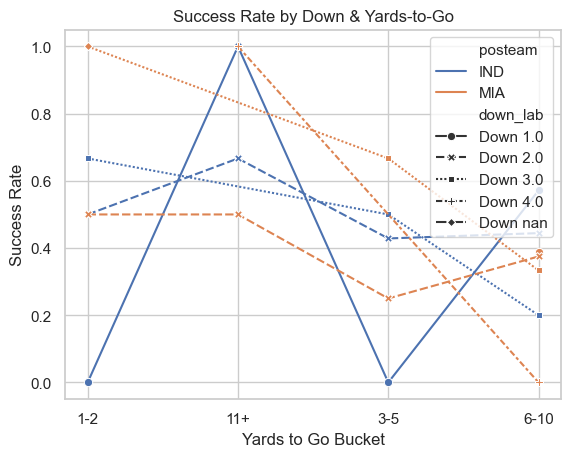

In [57]:
# Helper function to bucket yards-to-go
def bucket_ydstogo(x):
    if x <= 2:
        return "1-2"
    elif x <= 5:
        return "3-5"
    elif x <= 10:
        return "6-10"
    else:
        return "11+"

situ = (
    pbp_g1[pbp_g1['play_type'].isin(['pass', 'run'])]
    .assign(
        ytg_bucket=pbp_g1['ydstogo'].apply(bucket_ydstogo),
        down_lab="Down " + pbp_g1['down'].astype(str)
    )
    .groupby(['posteam', 'down_lab', 'ytg_bucket'])
    .agg(
        plays=('play_id', 'count'),
        success_rate=('success', 'mean'),
        epa_per_play=('epa', 'mean')
    )
    .reset_index()
)

sns.lineplot(data=situ[situ['posteam'].isin([TEAM, opp])],
             x='ytg_bucket', y='success_rate', hue='posteam', style='down_lab', markers=True)
plt.title('Success Rate by Down & Yards-to-Go')
plt.ylabel('Success Rate')
plt.xlabel('Yards to Go Bucket')
plt.show()

## For this plot, we'd like to see the EPA per play by field zone

In [58]:
fieldpos = pbp_g1[
    (~pbp_g1['yardline_100'].isna()) & 
    (pbp_g1['play_type'].isin(['run', 'pass']))
].copy()

# Create field_zone based on yardline_100
fieldpos['field_zone'] = np.select(
    [
        fieldpos['yardline_100'] >= 80,
        fieldpos['yardline_100'] >= 50,
        fieldpos['yardline_100'] >= 21
    ],
    [
        'Own 20-0',
        'Own 49-21',
        'Opp 49-21'
    ],
    default='Red Zone (<=20)'
)

In [59]:
fieldpos_summary = (
    fieldpos.groupby(['posteam', 'field_zone'], as_index=False)
    .agg(
        plays=('play_id', 'count'),           # total number of plays
        epa_per_play=('epa', 'mean'),         # average EPA
        success_rate=('success', 'mean')      # success rate
    )
)

In [60]:
opp = "MIA"  

filtered_fieldpos = fieldpos_summary[
    fieldpos_summary['posteam'].isin(['IND', opp])
]

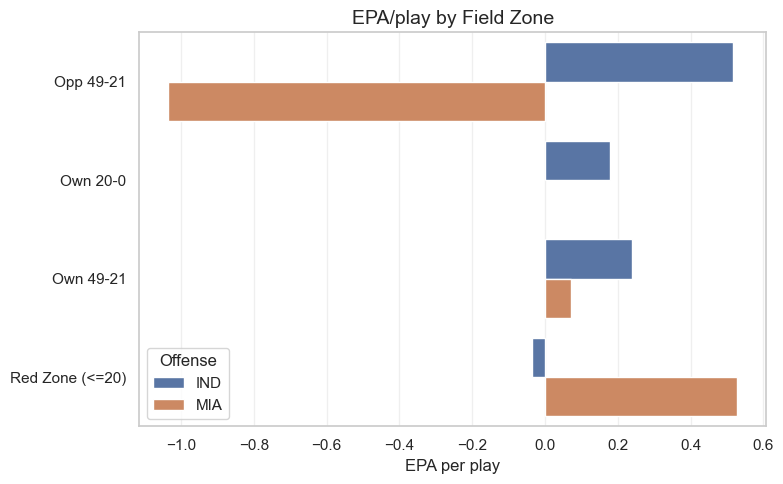

In [61]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=filtered_fieldpos,
    x='epa_per_play',
    y='field_zone',
    hue='posteam',
    dodge=True
)

plt.title("EPA/play by Field Zone", fontsize=14)
plt.xlabel("EPA per play")
plt.ylabel("")
plt.legend(title="Offense")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## In this plot, we wanted to look at the number of targets for the Colts receivers and measure their total EPA to get familiarized with player involvement for Game 1

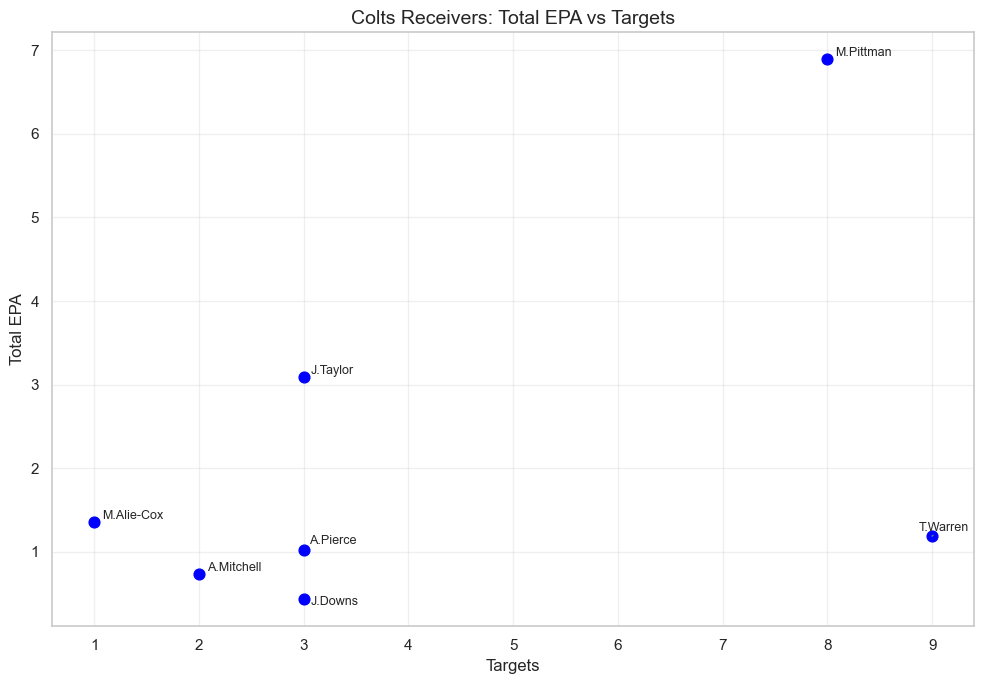

In [62]:
from adjustText import adjust_text

colts_targets = (
    pbp_g1[(pbp_g1['posteam'] == TEAM) & (pbp_g1['pass'] == 1)]
    .groupby('receiver_player_name', as_index=False)
    .size()
    .rename(columns={'size': 'targets'})
    .sort_values(by='targets', ascending=False)
)


epa_by_receiver = (
    pbp_g1[
        (pbp_g1['posteam'] == TEAM) &
        (pbp_g1['pass'] == 1) &
        (~pbp_g1['receiver_player_name'].isna())
    ]
    .groupby('receiver_player_name', as_index=False)
    .agg(
        targets=('receiver_player_name', 'count'),
        epa_sum=('epa', 'sum'),
        epa_mean=('epa', 'mean')
    )
    .sort_values(by='epa_sum', ascending=False)
)

plt.figure(figsize=(10, 7))
plt.scatter(epa_by_receiver['targets'], epa_by_receiver['epa_sum'], s=60, color='blue')

# Add labels
texts = []
for i, row in epa_by_receiver.iterrows():
    texts.append(
        plt.text(row['targets'], row['epa_sum'], row['receiver_player_name'], fontsize=9)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.title("Colts Receivers: Total EPA vs Targets", fontsize=14)
plt.xlabel("Targets")
plt.ylabel("Total EPA")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## This plot measures the EPA per play over the course of the game, divided into 4 quarters for each team, Colts and Dolphins

In [63]:
epa_by_q = (
    pbp_g1[
        (pbp_g1['qtr'].isin([1, 2, 3, 4])) &
        (pbp_g1['play_type'].isin(['pass', 'run']))
    ]
    .groupby(['posteam', 'qtr'], as_index=False)
    .agg(
        epa_per_play=('epa', 'mean'),
        success_rate=('success', 'mean')
    )
)

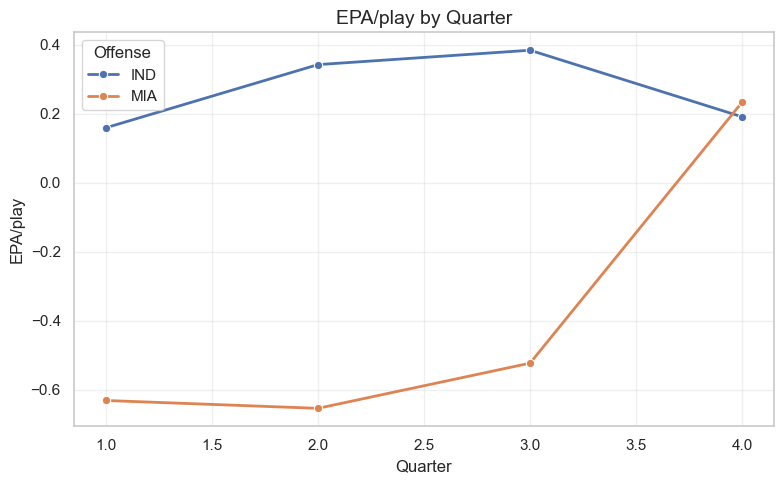

In [64]:
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=epa_by_q,
    x='qtr',
    y='epa_per_play',
    hue='posteam',
    marker='o',
    linewidth=2
)

plt.title("EPA/play by Quarter", fontsize=14)
plt.xlabel("Quarter")
plt.ylabel("EPA/play")
plt.legend(title="Offense")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Lastly, we wanted to look at the Colts' Rolling Pass Rate

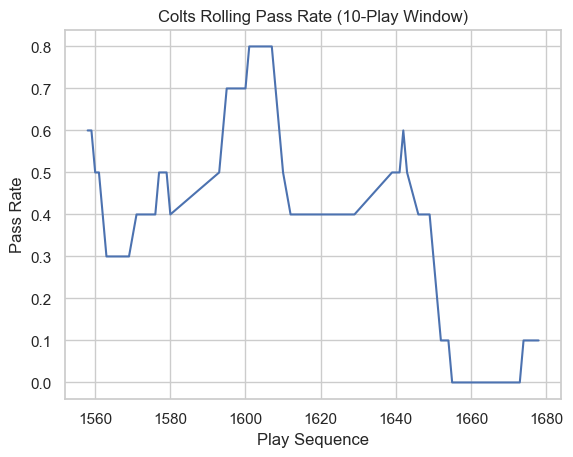

In [65]:
colts_seq = (
    pbp_g1[(pbp_g1['posteam'] == TEAM) & (pbp_g1['play_type'].isin(['pass','run']))]
    .copy()
)
colts_seq['pass_flag'] = np.where(colts_seq['play_type'] == 'pass', 1, 0)
colts_seq['pass_rate_10'] = colts_seq['pass_flag'].rolling(window=10).mean()

sns.lineplot(data=colts_seq, x=colts_seq.index, y='pass_rate_10')
plt.title("Colts Rolling Pass Rate (10-Play Window)")
plt.ylabel("Pass Rate")
plt.xlabel("Play Sequence")
plt.show()